In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score , accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
data = pd.read_csv('Online Retail.csv')

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data['Year'] = data['InvoiceDate'].dt.year
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['Weekday'] = data['InvoiceDate'].dt.weekday
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Time'] = data['InvoiceDate'].dt.strftime('%H:%M:%S')
data['Hour'] = data['InvoiceDate'].dt.hour
data['TimeOfDay'] = ['Early Morning' if x < 6 else ('Morning' if x < 12 else ('Noon' if x < 14 else ('Afternoon' if x < 18 else ('Evening' if x < 22 else 'Night')))) for x in data['Hour']]
data['Spent'] = data['Quantity'] * data['UnitPrice']
data['Transaction_type'] = data['Quantity'].apply(lambda x: 'Sold' if x < 0 else 'Bought')

In [ ]:
data.dropna(inplace=True)
data['Quantity'].fillna(data['Quantity'].mean(), inplace=True)
data['UnitPrice'].fillna(data['UnitPrice'].mean(), inplace=True)
data['InvoiceNo'].fillna('Unknown', inplace=True)
data['Description'].fillna('Unknown', inplace=True)
data['Country'].fillna('Unknown', inplace=True)
data['TimeOfDay'].fillna('Unknown', inplace=True)
data['Hour'].fillna(data['Hour'].mean(), inplace=True)
data['Weekday'].fillna(data['Weekday'].mean(), inplace=True)
data['Spent'].fillna(data['Spent'].mean(), inplace=True)
data['Transaction_type'].fillna('Unknown', inplace=True)

In [ ]:
quantity_by_description = data.groupby('Description')['Quantity'].sum().reset_index()
quantity_by_description.rename(columns={'Quantity': 'QuantityByDescription'}, inplace=True)

# total spent by each invoice
total_spent_by_invoice = data.groupby('InvoiceNo')['Spent'].sum().reset_index()
total_spent_by_invoice.rename(columns={'Spent': 'TotalSpentByInvoice'}, inplace=True)

# total quantity by country and product
country_product_sales = data.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()
country_product_sales.rename(columns={'Quantity': 'CountryProductSales'}, inplace=True)

# total no of unique ccountries per product
countries_per_product = data.groupby('Description')['Country'].nunique().reset_index()
countries_per_product.rename(columns={'Country': 'NoOfuniqueCountries'}, inplace=True)

# frequency of a product bought by description and country
product_country_freq = data.groupby(['Description', 'Country']).size().reset_index(name='Frequency')


# Merge total quantity by description back to the original data
data = data.merge(quantity_by_description, on='Description', how='left')

# Merge total spent by invoice back to the original data
data = data.merge(total_spent_by_invoice, on='InvoiceNo', how='left')

# Merge total quantity by country and product back to the original data
data = data.merge(country_product_sales, on=['Country', 'Description'], how='left')

# Merge the number of countries per product back to the original data
data = data.merge(countries_per_product, on='Description', how='left')

# Merge this frequency information back into the original dataframe
data = data.merge(product_country_freq, on=['Description', 'Country'], how='left')


data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,...,Time,Hour,TimeOfDay,Spent,Transaction_type,QuantityByDescription,TotalSpentByInvoice,CountryProductSales,NoOfuniqueCountries,Frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,15.30,Bought,10753.0,139.12,10196.0,10,555
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,367.0,139.12,363.0,2,80
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,22.00,Bought,764.0,139.12,601.0,4,111
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,1547.0,139.12,1535.0,3,180
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010.0,12.0,...,08:26:00,8.0,Morning,20.34,Bought,1892.0,139.12,1880.0,3,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105135,545226,22139,RETROSPOT TEA SET CERAMIC 11 PC,3.0,2011-03-01 09:33:00,4.95,12428.0,Finland,2011.0,3.0,...,09:33:00,9.0,Morning,14.85,Bought,495.0,840.73,3.0,10,1
105136,545226,22957,SET 3 PAPER VINTAGE CHICK PAPER EGG,6.0,2011-03-01 09:33:00,2.95,12428.0,Finland,2011.0,3.0,...,09:33:00,9.0,Morning,17.70,Bought,1105.0,840.73,6.0,14,1
105137,545226,22860,EASTER TIN CHICKS PINK DAISY,6.0,2011-03-01 09:33:00,1.65,12428.0,Finland,2011.0,3.0,...,09:33:00,9.0,Morning,9.90,Bought,269.0,840.73,6.0,6,1
105138,545226,85213,MINI ZINC GARDEN DECORATIONS,24.0,2011-03-01 09:33:00,0.85,12428.0,Finland,2011.0,3.0,...,09:33:00,9.0,Morning,20.40,Bought,58.0,840.73,24.0,2,1


In [ ]:
# Initialize LabelEncoders for categorical columns
le_weekday = LabelEncoder()
le_hour = LabelEncoder()
le_country = LabelEncoder()
le_customer_id = LabelEncoder()
le_invoice_no = LabelEncoder()

# Fit and transform the categorical columns
data['Weekday'] = le_weekday.fit_transform(data['Weekday'])
data['Hour'] = le_hour.fit_transform(data['Hour'])
data['Country'] = le_country.fit_transform(data['Country'])
data['CustomerID'] = le_customer_id.fit_transform(data['CustomerID'])
data['InvoiceNo'] = le_invoice_no.fit_transform(data['InvoiceNo'])


features = ['Quantity' , 'UnitPrice', 'Spent' , 'TotalSpentByInvoice' , 'Country' , 'Weekday' , 'Hour' , 'CustomerID' , 'InvoiceNo']
target = 'TimeOfDay'

le_target = LabelEncoder()
data[target] = le_target.fit_transform(data[target])


X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average Cross-Validation Score: {np.mean(cv_scores):.2f}')


y_pred = model.predict(X_test)

accuracy = np.mean(cv_scores)
print('Accuracy:',accuracy)

cf = confusion_matrix(y_test, y_pred)
print('Confusion matrix \n :',cf)

target_names = [str(cls) for cls in le_target.classes_]

cr=classification_report(y_test, y_pred, target_names=target_names)
print('Classification report :',cr)

y_pred = y_pred.flatten()  # Make Y_pred a 1D array
y_test_values = y_test.values  # Extract values from Y_test DataFrame

result = pd.DataFrame({
    'Date': data.index[-len(y_test):],
    'Actual': y_test_values,  # Use the extracted values
    'Predicted': y_pred
})

print(result)

#Example


Cross-Validation Scores: [1. 1. 1. 1. 1.]
Average Cross-Validation Score: 1.00
Accuracy: 1.0
Confusion matrix 
 : [[45481     0     0     0]
 [    0  2485     0     0]
 [    0     0 30090     0]
 [    0     0     0 30035]]
Classification report :               precision    recall  f1-score   support

           0       1.00      1.00      1.00     45481
           1       1.00      1.00      1.00      2485
           2       1.00      1.00      1.00     30090
           3       1.00      1.00      1.00     30035

    accuracy                           1.00    108091
   macro avg       1.00      1.00      1.00    108091
weighted avg       1.00      1.00      1.00    108091

          Date  Actual  Predicted
0       432364       0          0
1       432365       0          0
2       432366       2          2
3       432367       0          0
4       432368       0          0
...        ...     ...        ...
108086  540450       0          0
108087  540451       3          3
108088  5404

In [ ]:
from operator import le

# Store label encoders in a dictionary
label_encoders = {
    'Weekday': le_weekday,
    'Hour': le_hour,
    'Country': le_country,
    'CustomerID': le_customer_id,
    'InvoiceNo': le_invoice_no,
    'TimeOfDay': le_target  # Add the target encoder as well
}
def predict_time_of_day(quantity, unit_price, spent, total_spent_by_invoice, country, weekday, hour, customer_id, invoice_no):
    input_data = pd.DataFrame({
        'Quantity': [quantity],
        'UnitPrice': [unit_price],
        'Spent': [spent],
        'TotalSpentByInvoice': [total_spent_by_invoice],
        'Country': [label_encoders['Country'].transform([country])[0] if country in label_encoders['Country'].classes_ else -1], # Handle unseen countries
        'Weekday': [label_encoders['Weekday'].transform([weekday])[0] if weekday in label_encoders['Weekday'].classes_ else -1], # Handle unseen weekdays
        'Hour': [hour],
        'CustomerID': [label_encoders['CustomerID'].transform([customer_id])[0] if customer_id in label_encoders['CustomerID'].classes_ else -1], # Handle unseen customer IDs
        'InvoiceNo': [label_encoders['InvoiceNo'].transform([invoice_no])[0] if invoice_no in label_encoders['InvoiceNo'].classes_ else -1]
    })
    prediction = model.predict(input_data)
    return label_encoders[target].inverse_transform(prediction)[0]

# Example usage
predicted_time_of_day = predict_time_of_day(
    quantity=10,
    unit_price=5.99,
    spent=59.9,
    total_spent_by_invoice=100.0,
    country='United Kingdom',
    weekday='Monday',
    hour=14,
    customer_id='C12345',
    invoice_no='563653'
)

print('Predicted TimeOfDay:',predicted_time_of_day)

Predicted TimeOfDay: 1


In [ ]:
features = ['UnitPrice' ,'Quantity' , 'Country' , 'CountryProductSales' , 'Frequency' , 'TotalSpentByInvoice']
target =  'NoOfuniqueCountries'

le_country = LabelEncoder()
data['Country'] = le_country.fit_transform(data['Country'])

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print('R2 Score:',r2)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:',mae)

Mean Squared Error: 0.4135068801409183
R2 Score: 0.9617630980210727
Mean Absolute Error: 0.17805662294067817


In [ ]:
y_pred = y_pred.flatten()  # Make Y_pred a 1D array
y_test_values = y_test.values  # Extract values from Y_test DataFrame

Results = pd.DataFrame({
    'Date': data.index[-len(y_test):],
    'Actual': y_test_values,  # Use the extracted values
    'Predicted': y_pred
})

print(Results)

          Date  Actual  Predicted
0       432364       1       1.00
1       432365       3       3.00
2       432366      11      11.00
3       432367      18      18.00
4       432368      10      10.00
...        ...     ...        ...
108086  540450       7       7.00
108087  540451      15      14.95
108088  540452       5       5.00
108089  540453       5       5.00
108090  540454       8       7.77

[108091 rows x 3 columns]


In [10]:
from operator import le

# Store label encoders in a dictionary
label_encoders = {
    'Country': le_country,
}
def predict_no_of_unique_countries(unit_price, quantity, country, country_product_sales, frequency, total_spent_by_invoice):
    input_data = pd.DataFrame({
        'UnitPrice': [unit_price],
        'Quantity': [quantity],
        'Country': [label_encoders['Country'].transform([country])[0]] if country in label_encoders['Country'].classes_ else -1,
        'CountryProductSales': [country_product_sales],
        'Frequency': [frequency],
        'TotalSpentByInvoice': [total_spent_by_invoice]
    })
    prediction = model.predict(input_data)
    rounded_prediction = round(prediction[0])
    return rounded_prediction


# Example usage
predicted_no_of_unique_countries = predict_no_of_unique_countries(
    unit_price=5.99,
    quantity=10,
    country='United Kingdom',
    country_product_sales=500,
    frequency=3,
    total_spent_by_invoice=100.0
)

print(f'Predicted NoOfUniqueCountries: {predicted_no_of_unique_countries}')


Predicted NoOfUniqueCountries: 1


<ipython-input-50-e513fa222a2d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='TimeOfDay', palette="muted")


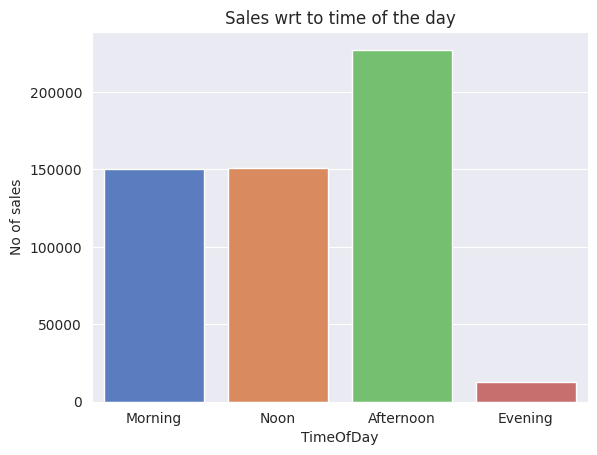

In [ ]:
sns.set_style("darkgrid")
sns.countplot(data=data, x='TimeOfDay', palette="muted")
plt.xlabel("TimeOfDay")
plt.ylabel("No of sales")
plt.title("Sales wrt to time of the day")
plt.show()

<ipython-input-21-d3489684cf8a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Weekday', palette="dark") #0=mon


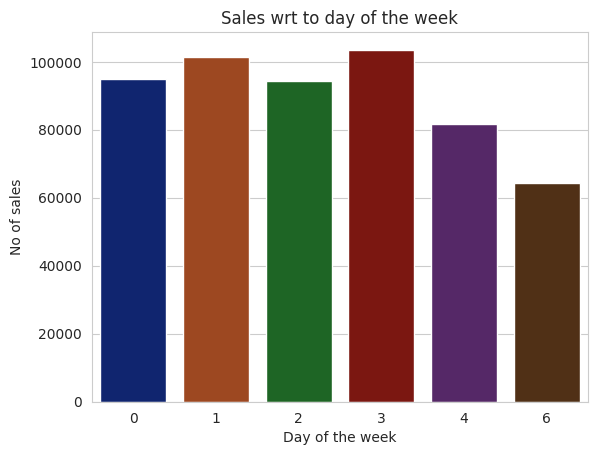

In [ ]:
sns.set_style("whitegrid")
sns.countplot(data=data, x='Weekday', palette="dark") #0=mon
plt.xlabel("Day of the week")
plt.ylabel("No of sales")
plt.title("Sales wrt to day of the week")
plt.show()

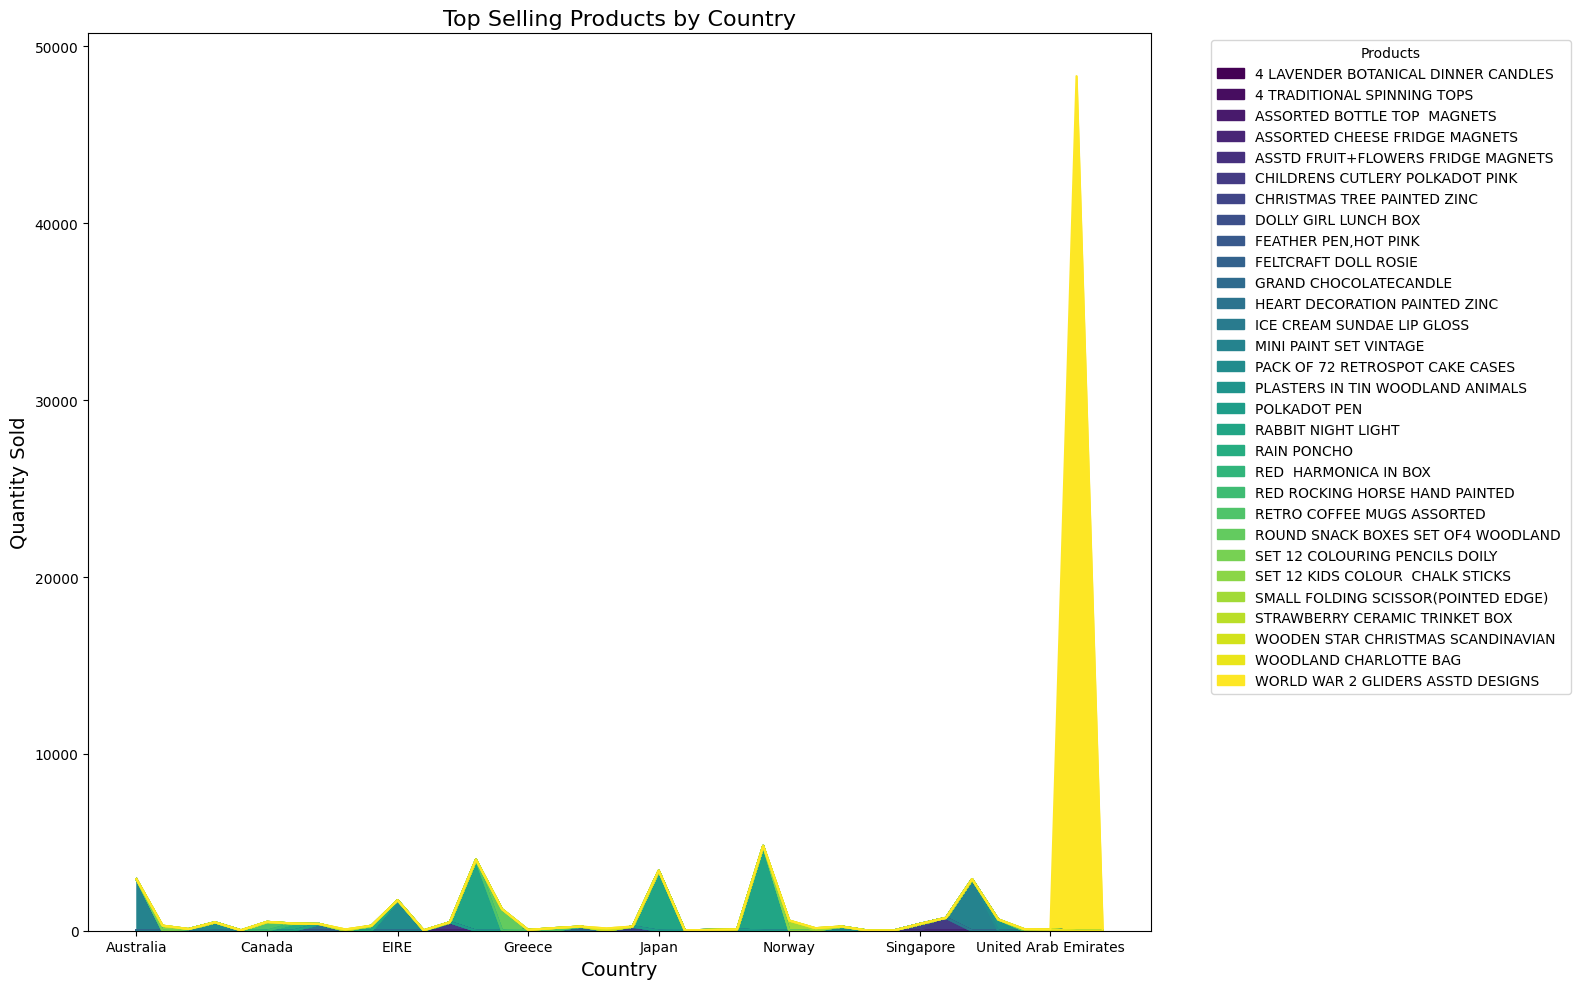

In [ ]:
top_selling_product_by_country = country_product_sales.loc[country_product_sales.groupby('Country')['CountryProductSales'].idxmax()]
print(top_selling_product_by_country)